https://wikidocs.net/32829 #판다스와 넘파이 호출 시 쓸 수 있는 것들

In [11]:
#필요 모듈 임포트

import warnings
warnings.filterwarnings(action='ignore')

import numpy as np #데이터 처리를 위한 라이브러리: Series, DataFrame, 조회, 읽기
import pandas as pd #수치 데이터 패키지: ndarray, np.zeros(), np.arange(), np.reshape(), 슬라이싱, 인덱싱, 연산, Matplotlib

import matplotlib.pyplot as plt #필요할 때 추가

from sklearn.preprocessing import OneHotEncoder, LabelEncoder # 머신러닝 툴 추가함
from sklearn.compose import make_column_transformer #
from sklearn.model_selection import train_test_split #

from sklearn.ensemble import RandomForestClassifier  #
from sklearn.ensemble import AdaBoostClassifier #
from sklearn.linear_model import LogisticRegression #
from sklearn.svm import SVC #
from sklearn.neighbors import KNeighborsClassifier #
import xgboost as xgb #

In [12]:
##데이터 불러오기
df = pd.read_csv("data/titanic.csv")

##===============원본
##데이터개요 확인
df.head() #불러온 전체 데이터 확인

##데이터 변수 확인
df.columns #변수이름 확인
df.columns.size #몇개의 변수가 있는지 확인
df.shape #전체 데이터의 행, 열 개수
df.dtypes #변수의 데이터 타입 (수치형으로 변환 위해)
df.isna().sum() #특징(변수)는 반드시 na가 있으면 안되므로 전체 na확인

##필요한 컬럼만 셀렉트 
selected_cols = ["Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked","Survived"] #12개 컬럼 중 11개 선택
data = df[selected_cols]


##================셀렉트한 수정본
##분석할 데이터개요 확인
data.head()

##데이터 변수 확인
data.columns #변수이름(컬럼) 확인
data.columns.size #몇개의 변수
data.shape #행의 갯수, 열의 개수
data.dtypes #변수의 데이터 타입 (수치형으로 변환 위해)
data.isna().sum() #특징(변수)는 반드시 na가 있으면 안되므로 na확인

data.info() #전체 정보 확인

##Na정리
#1.drop데이터 선별(컬럼)
# Cabin
#2.drop데이터 선별(로우)
#Embarked
#data.drop(data.Embarked.isna(),axis=0)

data = data.loc[~data.Embarked.isna(),:] #객실정보 없는거 빼고 정렬해서 가져오기
data.isna().sum() ##빈값확인, 데이터 수정으로 Embarked는 빈값이 안 나옴 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
 10  Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
Survived      0
dtype: int64

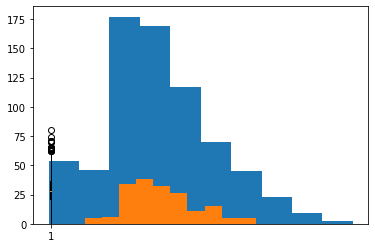

In [13]:
#데이터 전처리 EDA
#3.imputation 데이터 채우기()
#수치형 --> 세심한 주의(평균 사용시 주의 요망)
#범주형 --> real Na? 범주외의 대체값  

##빈값687개인 Cabin EDA 데이터 채우기()
data.Cabin.value_counts() #들어있는 정보 확인
data.Cabin.str[:1].value_counts() #들어있는 열의 앞 글자만 따서 갯수 세기(확인용)
data.head() #데이터 가공 후 확인해보니 Pclass랑 Cabin이 연관성이 있어보이네
data.groupby(["Pclass","Cabin"]).count() # 관계성확인
data.Cabin.fillna("N",inplace=True) #빈 객실 정보는 N으로 채우기
data.isna().sum() #빈값 확인
# data.Cabin.str[:1].value_counts() #잘 들어가있나 확인, 들어있는 열의 앞 글자만 따서 갯수 세기(확인용)
# data.loc[data.Cabin.isin(["T","G"]),:] #객실, 왜 확인한거?ㅋㅋ
newCabin = data.Cabin.str[:1] #새 데이터 칼럼으로 만들기
data.drop("Cabin",axis=1,inplace=True) #원래 데이터 버리기
data["Cabin"] = newCabin #캐빈에 있는 데이터를 뉴캐빈으로 이전한다

## 빈값177개인 Age EDA 데이터 채우기()
data.Age.describe()
plt.hist(data.Age) #시각화도구 임포트 import matplotlib.pyplot as plt
data.loc[data.Age <= 18,:]
data.loc[data.Age.isna(),["Pclass","Fare"]] ##Age값이NULL인 사람의 선실과 요금
data.groupby(["Pclass","Sex"])["Fare"].mean() #요금이 성별에도 연관있나 확인


###Age예측을 위한 회귀모델 생성
from sklearn.ensemble import RandomForestRegressor #트리를 랜덤하게 나온 것을 투표하여 결정
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #Categorical 데이터를 Numerical 로 변환 # 0 or 1
df_age = data.loc[~data.Age.isna(),["Pclass","Sex","Fare","Embarked","Age"]]
pred_age = data.loc[data.Age.isna(),["Pclass","Sex","Fare","Embarked"]]

le_sex = LabelEncoder() #라벨인코더
le_sex.fit(df_age.Sex)
newSex = le_sex.transform(df_age.Sex)

le_embarked = LabelEncoder()
le_embarked.fit(df_age.Embarked)
newEmbarked = le_embarked.transform(df_age.Embarked)

df_age.drop(["Sex","Embarked"],axis=1,inplace=True)
newCols = np.c_[newSex,newEmbarked] #두개 묶어주기
df_age = pd.concat([pd.DataFrame(newCols,index=df_age.index),df_age],axis=1)
age_model = RandomForestRegressor()
age_model.fit(df_age.iloc[:,:-1],df_age.iloc[:,-1]) #모든것의 끝 한값


###Null age 예측실행
## print(df_age.iloc[:,:-1]) #값확인 
## print(pred_age.iloc[:,:-1]) #예측값확인 두개가 같은 값이 나와야 함 
newSex = le_sex.transform(pred_age.Sex)
newEmbarked = le_embarked.transform(pred_age.Embarked)
pred_age.drop(["Sex","Embarked"],axis=1,inplace=True)
newCols = np.c_[newSex,newEmbarked] 
pred_age = pd.concat([pd.DataFrame(newCols,index=pred_age.index),pred_age],axis=1)
newAge = age_model.predict(pred_age)
plt.hist(newAge)
pred_age["Age"] = newAge

## df_age, pred_age 조인
# pd.merge(df_age,pred_age,how="outer").head(10)
# len(pd.merge(df_age,pred_age,how="outer"))
# pd.merge(df_age,pred_age,how="outer").isna().sum()
newAge = pd.merge(df_age,pred_age,how="outer")[["Age"]]
#newAge.index != data.index
newAge.reset_index(inplace=True)
newAge.drop("index",axis=1,inplace=True)

data.isna().sum() #다 드롭됐는지 확인

## 원래data에 newAge컬럼 추가
data.reset_index(inplace=True)
data.drop(["Age","index"],axis=1,inplace=True)
data["Age"] = newAge

#data.dtypes


###파생변수 생성 (Name) 결혼유무판단
###data.Name 에서 Mrs.가 존재하면 기혼 
###data.Name 에서 Mr.가족(SibSp)이 있으면 기혼 혹은 25세 이상이면 기혼
married = np.where((data.Name.str.contains("Mrs."))|((data.Name.str.contains("Mr."))&(data.SibSp > 0)),1,0) #매리드 데이터 만들어서 새 칼럼 추가하기
data["Married"]=married
data.head()


###티켓 연관성 확인
data.Ticket.value_counts() #시리즈 데이터 인것을 확인
data.Ticket.value_counts()[data.Ticket.value_counts()]
## Name, Ticket컬럼 제거
data.drop(["Name","Ticket"],axis=1,inplace=True)
data.head()


#preprocessing
## categorical 변수에서 종류(unique)가 2개 이상이면 정수인코딩, 나머지는 원핫인코딩
###data컬럼 타입확인
#obj = data.dtypes[data.dtypes == "object"].index
#data[obj[0]].unique().size

##수치형(연속형)변수일 경우 정규화(MinMax,Robust,Standard)
# mmScale = (X-np.min(X))/(np.max(X)-np.min(x))
# rbScale = (X-np.percentile(X,50))/(np.percentile(X,75) - np.percentile(X,25))
# stScale = (X-X.mean(x))/(X.std(X))


# OneHot 방법1
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# newPclass = OneHotEncoder().fit_transform(data[["Pclass"]]).toarray()
# newSex = OneHotEncoder().fit_transform(data[["Sex"]]).toarray()
# newSibSp = OneHotEncoder().fit_transform(data[["SibSp"]]).toarray()
# newCols = np.c_[newPclass,newSex,newSibSp]
# newCols.shape

# OneHot 방법 2 with Age data
plt.boxplot(data.Age) #나이를 구간나누기
newAge = np.where(data.Age > np.percentile(data.Age,90),0,
                 np.where(data.Age > np.percentile(data.Age,75),1,
                        np.where(data.Age > np.percentile(data.Age,25),2,
                                3)))
data.drop("Age",axis=1,inplace=True)
data["Age"] = newAge

# OneHot 방법2 #컬럼때문에 순서도 중요해
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
selected_cols = ["Pclass","Sex","SibSp","Age","Parch","Embarked","Cabin","Married"]
ct = make_column_transformer(
    (OneHotEncoder(),selected_cols)
)
#ct.fit_transform(data).toarray().shape
newCols = ct.fit_transform(data).toarray()
data.drop(selected_cols,axis=1,inplace=True) #내부변경
data = pd.concat([pd.DataFrame(newCols),data],axis=1)
data.shape


# Train, test 분리
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [22]:
#XGboost 모델을 위한 파라미터 설정
param = { 'n_estimators':100,
         'learning_rate':0.1,
         'gamma':1,
        'max_depth':10,
         'subsample':0.75,
        'colsample_bytree':1,
        'verbosity':0}

#model instance생성
ada_model = AdaBoostClassifier()
rf_model = RandomForestClassifier()
lr_model = LogisticRegression()
svc_model = SVC(probability=True)
knn_model = KNeighborsClassifier()
bst_model = xgb.XGBClassifier(**param)

#Model Training 학습
ada_model.fit(X_train,y_train)
rf_model.fit(X_train,y_train) 
lr_model.fit(X_train,y_train) 
svc_model.fit(X_train,y_train) 
knn_model.fit(X_train,y_train)

X_meta = np.c_[rf_model.predict(X_train),ada_model.predict(X_train),lr_model.predict(X_train),svc_model.predict(X_train),knn_model.predict(X_train)]

bst_model.fit(X_meta,y_train)



X_meta_test = np.c_[rf_model.predict(X_test),ada_model.predict(X_test),lr_model.predict(X_test),svc_model.predict(X_test),knn_model.predict(X_test)]
print('rf_model : ', rf_model.score(X_test,y_test))
print('ada_model : ', ada_model.score(X_test,y_test))
print('lr_model : ', lr_model.score(X_test,y_test))
print('svc_model : ', svc_model.score(X_test,y_test))
print('knn_model : ', knn_model.score(X_test,y_test))
print('bst_model : ', bst_model.score(X_meta_test,y_test))
# print("hard_voting_model :",hard_acc)
# print("soft_voting_model :",hard_acc)

rf_model.feature_importances_
hard_voting_result = (rf_model.predict(X_test) + ada_model.predict(X_test) + lr_model.predict(X_test) + svc_model.predict(X_test) + knn_model.predict(X_test)+bst_model.predict(X_meta_test))
hard_acc = sum(np.where(hard_voting_result > 2,1,0) == y_test)/ hard_voting_result.size
print('hard_voting_result : ',hard_acc)

soft_voting_result = (rf_model.predict_proba(X_test) + ada_model.predict_proba(X_test) + lr_model.predict_proba(X_test) + svc_model.predict_proba(X_test) + bst_model.predict_proba(X_meta_test))
soft_acc = sum(np.array(soft_voting_result[:,0]<soft_voting_result[:,1],dtype='int') == y_test)/ y_test.size
print('soft_voting_result : ',soft_acc)

# 위에꺼 이렇게도 표현 가능=====
# rf_result = rf_model.predict_proba(X_test)
# ada_result = ada_model.predict_proba(X_test)
# lr_result = lr_model.predict_proba(X_test)
# svc_result = svc_model.predict_proba(X_test)
# knn_result = knn_model.predict_proba(X_test)
# soft_voting_result = rf_model+ada_model+lr_model+svc_model+knn_model
#==============================


v1 = rf_model.predict(X_train)
v2 = ada_model.predict(X_train)
v3 = lr_model.predict(X_train)
v4 = svc_model.predict(X_train)
v5 = bst_model.predict(X_meta)
X_train_meta = np.c_[v1,v2,v3,v4,v5]
meta_model.fit(X_train_meta,y_train)

v1 = rf_model.predict(X_test)
v2 = ada_model.predict(X_test)
v3 = lr_model.predict(X_test)
v4 = svc_model.predict(X_test)
v5 = bst_model.predict(X_meta_test)
X_test_meta = np.c_[v1,v2,v3,v4,v5]
meta_model.score(X_test_meta,y_test)


print('rf_model : ', rf_model.score(X_test,y_test))
print('ada_model : ', ada_model.score(X_test,y_test))
print('lr_model : ', lr_model.score(X_test,y_test))
print('svc_model : ', svc_model.score(X_test,y_test))
print('knn_model : ', knn_model.score(X_test,y_test))
print('*--------------------------------------------*')
print('hard_acc : ', hard_acc)
print('soft_acc : ', soft_acc)
print('*--------------------------------------------*')
print('meta_model : ', meta_model.score(X_test_meta,y_test))

rf_model :  0.797752808988764
ada_model :  0.7528089887640449
lr_model :  0.7528089887640449
svc_model :  0.651685393258427
knn_model :  0.7471910112359551
bst_model :  0.797752808988764
hard_voting_result :  0.7808988764044944
soft_voting_result :  0.797752808988764
rf_model :  0.797752808988764
ada_model :  0.7528089887640449
lr_model :  0.7528089887640449
svc_model :  0.651685393258427
knn_model :  0.7471910112359551
*--------------------------------------------*
hard_acc :  0.7808988764044944
soft_acc :  0.797752808988764
*--------------------------------------------*
meta_model :  0.797752808988764
